# 강화 학습

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
import matplotlib.animation as animation
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices("GPU"):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# 부드러운 애니메이션을 위해
mpl.rc("animation", html="jshtml")

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print("그림 저장 " + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

2023-06-11 08:47:19.525216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 08:47:22.966867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 08:47:23.196102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 08:47:23.196337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

## OpenAI 짐

이 노트북은 강화학습 알고리즘을 개발하고 평가하는 훌륭한 도구인 [OpenAI 짐(gymnasium)](https://gymnasium.farama.org/)을 사용한다. 학습 에이전트가 상호작용하기 위한 환경을 많이 제공한다. 먼저 `gymnasium`을 임포트한다:

In [2]:
import gymnasium as gym

가능한 환경 목록을 확인한다:

In [3]:
gym.envs.registry.values()

dict_values([EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=Fals

Cart-Pole은 매우 간단한 환경으로 왼쪽과 오른쪽으로 움직이는 카트와 그 위에 수직으로 놓여 있는 막대로 구성된다. 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여 막대가 바로 서 있도록 만들어야 한다.

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

`reset()` 메서드를 호출해 환경을 초기화한다. 이 메서드는 관측을 반환한다:

In [5]:
obs, _ = env.reset(seed=42)

관측은 환경에 따라 다르다. 이 경우 4개의 실수로 구성된 1D 넘파이 배열이다. 카트의 수평 위치, 속도, 막대의 각도(0=수직), 각속도를 나타낸다.

In [6]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

환경은 `render()` 메서드를 호출하여 시각화할 수 있다. 그리고 렌더링 모드(환경에 따른 렌더링 옵션)를 선택할 수 있다.

**경고**: (Cart-Pole을 포함해) 일부 환경은 화면 접근 권한이 필요하다. `render_mode="rgb_array"`로 지정하더라도 별도의 윈도우를 연다. 일반적으로 이 윈도우를 무시할 수 있다.

In [7]:
env.render()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

이 예에서는 `render_mode="rgb_array"`로 지정해 환경 이미지를 넘파이 배열로 받는다:

In [8]:
img = env.render()
img.shape

(400, 600, 3)

In [9]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

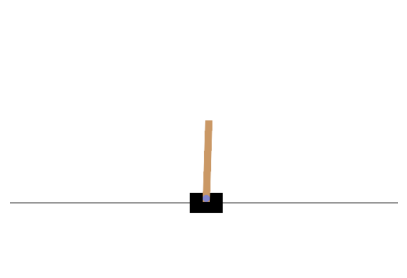

In [10]:
plot_environment(env)
plt.show()

환경과 상호작용하는 방법을 알아 본다. 에이전트는 "행동 공간"(가능한 행동의 집합)에서 하나의 행동을 선택해야 한다. 이 환경의 행동 공간을 다음처럼 확인한다:

In [11]:
env.action_space

Discrete(2)

단 두 개의 행동이 가능하다: 왼쪽 또는 오른쪽으로 가속한다.

막대가 오른쪽으로 기울어져 있기 때문에(`obs[2] > 0`), 카트를 오른쪽으로 가속한다:

In [12]:
action = 1  # 오른쪽으로 가속
obs, reward, terminated, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

이제 카트가 오른쪽으로 움직였다(`obs[1] > 0`). 막대가 여전히 오른쪽으로 기울었다(`obs[2] > 0`). 하지만 각속도가 음수이므로(`obs[3] < 0`) 다음 스텝에서는 왼쪽으로 기울 것이다.

그림 저장 cart_pole_plot


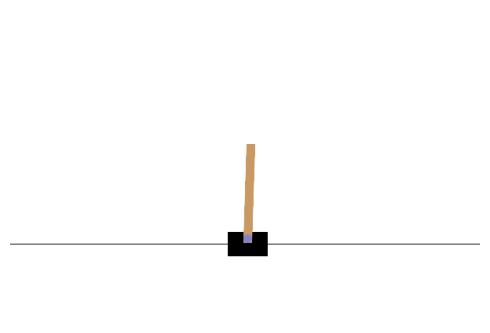

In [13]:
plot_environment(env)
save_fig("cart_pole_plot")

요청한 대로 실행된다!

환경은 이전 스텝에서 얼마나 많은 보상을 받는지 에이전트에게 알린다:

In [14]:
reward

1.0

게임이 끝나면 환경은 `terminated = True`나 `truncated = True`를 반환한다:

In [15]:
terminated, truncated

(False, False)

마지막으로 `info`는 훈련이나 디버깅에 유용한 추가적인 정보를 담은 환경에 특화된 딕셔너리이다. 예를 들어 일부 게임에서는 얼마나 많은 에이전트의 생명이 몇 개가 남아 있는지 나타낸다.

In [16]:
info

{}

환경이 재설정된 순간부터 종료될 때까지 스텝 시퀀스를 "에피소드"라고 한다. 에피소드 끝에서(즉, `step()`이 `terminated = True`나 `truncated = True`를 반환할 때), 계속하기 전에 환경을 재설정해야 한다.

In [17]:
if terminated | truncated:
    env.reset()

그럼 어떻게 막대를 똑바로 유지할 수 있을까? 이를 위해 정책을 정의해야 한다. 에이전트가 매 스텝마다 행동을 선택하기 위해 사용할 전략이다. 어떤 행동을 선택할지 결정하기 위해 지난 행동과 관측을 모두 사용할 수 있다.

**간단한 하드 코딩 정책**

간단한 정책을 하드 코딩한다. 막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 움직이고 오른쪽으로 기울어지면 반대로 움직인다. 어떻게 작동하는지 확인한다:

In [18]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1


totals = []
for episode in range(500):
    episode_rewards = 0
    obs, _ = env.reset()
    while True:
        action = basic_policy(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        episode_rewards += reward
        if terminated | truncated:
            break
    totals.append(episode_rewards)

In [19]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.18, 9.015963620157304, 24.0, 72.0)

예상대로 이 전략은 너무 단순하다. 최대로 막대를 유지한 스텝 횟수가 72이다. 이 환경은 에이전트가 막대를 200 스텝 이상 유지해야 해결된 것으로 간주한다.

하나의 에피소드를 시각화한다:

In [20]:
frames = []
obs, _ = env.reset()
while True:
    img = env.render()
    frames.append(img)
    action = basic_policy(obs)
    obs, _, terminated, truncated, _ = env.step(action)
    if terminated | truncated:
        break

애니메이션을 출력합니다:

In [21]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    anim = animation.FuncAnimation(
        fig, update_scene, len(frames), fargs=(frames, patch), repeat=repeat, interval=interval
    )
    plt.close()
    return anim

In [22]:
plot_animation(frames)

확실히 이 방법은 불안정해서 약간 흔들리면 막대가 너무 기울어져 게임이 끝난다. 이 보다는 더 똑똑한 전략이 필요하다!

## 신경망 정책

관측을 입력으로 받고 각 관측에 대해 선택할 행동의 확률을 출력하는 신경망을 만든다. 행동을 선택하기 위해 신경망은 각 행동의 확률을 추정한다. 이 추정된 확률에 따라 랜덤하게 행동을 선택한다. Cart-Pole 환경의 경우 두 개의 가능한 행동이 있다(왼쪽과 오른쪽). 따라서 하나의 출력 뉴런만 있으면 된다. 이 뉴런은 행동 0(왼쪽)의 확률 `p`를 출력한다. 물론 행동 1(오른쪽)의 확률은 `1 - p`이다.

In [23]:
keras.backend.clear_session()
n_inputs = 4  # == env.observation_space.shape[0]
model = keras.Sequential([keras.layers.Dense(5, "elu", input_shape=[n_inputs]), keras.layers.Dense(1, "sigmoid")])

2023-06-11 08:47:26.786416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 08:47:26.786671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 08:47:26.786857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 08:47:28.211421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 08:47:28.211729: I tensorflow/compile

이 환경에서는 지난 행동과 관측을 무시한다. 각 관측이 완전한 환경의 상태를 담고 있기 때문이다. 은닉 상태가 있다면 환경의 은닉 상태를 추정하기 위해 지난 행동과 관측을 고려한다. 예를 들어, 이 환경이 카트의 위치만 제공하고 속도를 알려 주지 않는다면, 현재 속도를 추정하기 위해 현재 관측 뿐만 아니라 지난 관측도 고려한다. 또 다른 예는 관측에 잡음이 있는 경우이다. 가장 가능성 있는 현재 상태를 추정하기 위해 지난 몇 개의 관측을 사용한다. 이 문제는 매우 간단하다. 현재 관측에 잡음이 없고 환경의 모든 상태가 담긴다.

정책 네트워크가 출력한 확률 중에서 가장 높은 확률을 가진 행동을 선택하지 않고 랜덤한 행동을 선택하는 이유가 궁금할지 모른다. 이 방법은 에이전트가 새로운 행동을 탐험하는 것과 잘 동작하는 행동을 활용하는 것 사이에 밸런스를 찾도록 한다. 비유를 들겠다. 한 음식점에 처음 방문했다고 가정한다. 모든 음식에 대한 선호도가 동일하다면 랜덤하게 하나를 선택한다. 이 음식이 좋다고 느낀다면 다음 번에 이 음식을 주문할 확률을 높일 수 있다. 하지만 이 확률을 100%로 높여서는 안 된다. 그렇지 않으면 다른 음식을 시도해 볼 수 없다. 어쩌면 다른 음식이 이번에 먹은 것보다 훨씬 더 좋을 수도 있다.

모델을 실행하여 한 에피소드를 플레이하고 애니메이션을 위한 프레임을 반환하는 함수를 작성한다:

In [24]:
from numpy.random import default_rng

rng = default_rng()


def render_policy_net(model):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, _ = env.reset()
    while True:
        frames.append(env.render())
        left_proba = model.predict(obs.reshape(1, -1), use_multiprocessing=True)
        action = int(rng.random() > left_proba)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated | truncated:
            break
    env.close()
    return frames

랜덤하게 초기화된 정책 네트워크가 얼마나 잘 수행하는지 확인한다:

In [25]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 13ms/step


2023-06-11 08:47:31.206850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 14ms/step


아주 나쁘다. 이 신경망은 더 배워야 한다. 먼저 앞에서 사용한 기본적인 정책을 학습할 수 있는지 확인한다. 막대가 왼쪽으로 기울면 왼쪽으로 움직이고, 오른쪽으로 기울면 오른쪽으로 움직이도록 한다.

같은 신경망으로 동시에 50개의 다른 환경을 플레이한다(이렇게 하면 각 스텝마다 다양한 훈련 배치를 얻는다). 그리고 5000번 반복 동안에 훈련한다. 게임이 종료되면 환경을 재설정한다. 사용자 정의 훈련 루프를 사용하여 모델을 훈련하기 때문에 훈련 스텝마다 환경에 앞서 예측을 쉽게 만들 수 있다.

In [26]:
n_environments = 50
n_iterations = 1  # 5000
envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
observations = [env.reset()[0] for env in envs]
optimizer = keras.optimizers.experimental.RMSprop()
loss_fn = keras.losses.BinaryCrossentropy()
for iteration in range(n_iterations):
    # angle < 0이면 proba(left) = 1., 그렇지 않으면 proba(left) = 0.이 된다.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.math.reduce_mean(loss_fn(target_probas, left_probas))
    print(f"Iteration: {iteration}, Loss: {loss.numpy():.3f}", end="\r")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (rng.random((n_environments, 1)) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, _, terminated, truncated, _ = env.step(actions[env_index][0])
        observations[env_index] = obs if not terminated | truncated else env.reset()[0]
for env in envs:
    env.close()

2023-06-11 08:47:32.832011: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x367bc9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-11 08:47:32.832055: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-06-11 08:47:32.921727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-11 08:47:35.916784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-06-11 08:47:36.193060: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-11 08:47:36.343586: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [27]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 13ms/step


정책을 잘 학습했다. 이제 스스로 더 나은 정책을 학습할 수 있는지 확인한다.

## 정책 그레이디언트

이 신경망을 훈련하려면 타깃 확률 `y`를 정의해야 한다. 행동이 좋으면 해당 확률을 증가시키고 반대로 나쁘면 감소시킨다. 하지만 행동이 좋은지 나쁜지 어떻게 알까? 대부분 행동의 효과가 지연되어 나타나기 때문에 한 에피소드에서 점수를 얻거나 잃을 때 어떤 행동이 이 결과에 기여했는지 명확하지 않다. 마지막 행동일까? 아니면 마지막에서 10번째 행동일까? 아니면 50 스텝 이전의 행동일까? 이를 _신용 할당 문제_ 라고 부른다.

_정책 그레이디언트_ 알고리즘은 이 문제를 해결하기 위해 먼저 여러 개의 에피소드를 플레이하고 그다음 좋은 에피소드에 있는 행동의 가능성을 조금 더 높이고, 나쁜 에피소드에 있는 행동의 가능성을 조금 낮춘다. 먼저 플레이해보고 다시 돌아가서 수행한 작업을 생각해 본다.

이 모델을 사용해 하나의 스텝을 플레이하는 함수를 만든다. 지금은 선택한 행동이 모두 좋다고 가정하고 손실과 그레이디언트를 계산한다(그레이디언트를 저장하고 나중에 행동이 좋은지 나쁜지에 따라 수정한다):

In [28]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = tf.random.uniform([1, 1]) > left_proba
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.math.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, _ = env.step(int(action[0, 0].numpy()))
    return obs, reward, terminated, truncated, grads

`left_proba`가 높으면 `action`이 `False`가 될 가능성이 높다(0~1 사이에서 균등 분포로 난수를 샘플링하면 `left_proba`보다 높지 않을 가능성이 높기 때문에). 그리고 `False`를 숫자로 바꾸면 0이므로 `y_target`은 1 - 0 = 1이다. 다른 말로 하면 타깃을 1로 지정하는 것은 왼쪽일 확률을 100%로 가정한다는 의미이다(따라서 올바른 행동을 선택했다).

이제 `play_one_step()` 함수를 사용해 여러 개의 에피소드를 플레이하고 에피소드와 스텝마다 모든 보상과 그레이디언트를 반환하는 또 다른 함수를 만든다:

In [29]:
def play_multiple_episodes(env, n_episodes, model, loss_fn):
    all_rewards = []
    all_grads = []
    for _ in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, _ = env.reset()
        while True:
            obs, reward, terminated, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if terminated | truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

정책 그레이디언트 알고리즘은 모델을 사용해 여러 번 에피소드를 플레이한다(예를 들어 10번). 그다음 모든 보상을 할인하고 정규화한다. 이를 위한 함수를 만들어 본다. 첫 번째 함수는 할인된 보상을 계산한다. 두 번째 함수는 여러 에피소드에 걸쳐 할인된 보상을 정규화한다.

In [30]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

3개의 행동을 수행하고 각 행동의 보상이 10, 0, -50이라고 가정해 본다. 80%의 할인 계수를 사용하면 세 번째 행동은 -50(마지막 보상의 100%)를 받지만 두 번째 행동은 -40(마지막 보상의 80%)만 받는다. 그리고 첫 번째 행동은 -40의 80%(-32)에 첫 번째 보상(+10)의 100%를 받는다. 따라서 할인된 보상의 합은 -22가 된다:

In [31]:
discount_rewards([10, 0, -50], .8)

array([-22, -40, -50])

전체 에피소드에 대해 모든 할인된 보상을 정규화하기 위해 전체 할인된 보상의 평균과 표준 편차를 계산한다. 그리고 할인된 보상에서 평균을 빼고 표준 편차를 나눈다:

In [32]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], .8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [33]:
n_iterations = 1  # 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = .95

In [34]:
optimizer = keras.optimizers.Adam(.01)
loss_fn = keras.losses.BinaryCrossentropy()

In [35]:
keras.backend.clear_session()
model = keras.Sequential([keras.layers.Dense(5, "elu", input_shape=[4]), keras.layers.Dense(1, "sigmoid")])

In [36]:
env = gym.make("CartPole-v1")
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print(f"Iteration: {iteration}, mean rewards: {total_rewards / n_episodes_per_update:.1f}", end='\r')
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.math.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ],
            0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
env.close()

In [37]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 14ms/step


## 마르코프 결정 과정

**마르코프 연쇄**

In [38]:
transition_probabilities = [  # shape=[s, s']
    [.7, .2, 0., .1],  # s0에서 s0, s1, s2, s3까지
    [0., 0., .9, .1],  # s1에서 ...까지
    [0., 1., 0., 0.],  # s2에서 ...까지
    [0., 0., 0., 1.]  # s3에서 ...까지
]
n_max_steps = 50


def print_sequence():
    current_state = 0
    print("States:", end='')
    for _ in range(n_max_steps):
        print(f" {current_state}", end='')
        if current_state == 3:
            break
        current_state = rng.choice(4, p=transition_probabilities[current_state])
    else:
        print("...", end='')
    print()


for _ in range(10):
    print_sequence()

States: 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3
States: 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3
States: 0 3
States: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3
States: 0 1 2 1 2 1 2 1 3
States: 0 0 0 3
States: 0 0 0 0 0 0 0 3
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3
States: 0 0 0 3


**마르코프 결정 과정**

전이 확률, 보상, 가능한 행동을 정의해 보자. 예를 들어, 상태 s0에서 행동 a0가 선택되면 0.7의 확률로 상태 s0로 가고 +10 보상을 받는다. 그리고 0.3의 확률로 상태 s1으로 가고 보상이 없다. 상태 s2로는 이동하지 않는다(따라서 전이 확률은 `[0.7, 0.3, 0.0]`이고 보상은 `[+10, 0, 0]`이다):

In [39]:
transition_probabilities = [  # shape=[s, a, s']
    [[.7, .3, 0.], [1., 0., 0.], [.8, .2, 0.]], [[0., 1., 0.], None, [0., 0., 1.]], [None, [.8, .1, .1], None]
]
rewards = [  # shape=[s, a, s']
    [[10, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, -50]], [[0, 0, 0], [40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

**Q-가치 반복**

In [40]:
Q_values = np.full((3, 3), -np.inf)  # 불가능한 행동은 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.  # 모든 가능한 행동에 대해

In [41]:
gamma = .9  # 할인 계수
history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [
                    transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.amax(Q_prev[sp]))
                    for sp in range(3)
                ]
            )
history1 = np.array(history1)

In [42]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [43]:
np.argmax(Q_values, 1)

array([0, 0, 1])

할인 계수 0.9를 사용했을 때 이 MDP의 최적 정책은 상태 s0에서 행동 a0를 선택하고, 상태 s1에서 행동 a0를 선택하고, 마지막으로 상태 s2에서 행동 a1(선택 가능한 유일한 행동)을 선택하는 것이다.

할인 계수 0.95로 시도해 보자:

In [44]:
Q_values = np.full((3, 3), -np.inf)  # 불가능한 행동에 대해서는 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.  # 모든 가능한 행동에 대해서

In [45]:
gamma = .95  # 할인 계수
for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [
                    transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.amax(Q_prev[sp]))
                    for sp in range(3)
                ]
            )

In [46]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [47]:
np.argmax(Q_values, 1)

array([0, 2, 1])

이제 정책이 바뀌었다! 상태 s1에서 불 속으로 들어가는 것을 선택한다(행동 a2). 할인 계수가 크기 때문에 에이전트가 미래에 더 많은 가치를 두기 때문에 미래 보상을 얻기 위해 당장의 불이익을 감내한다.

## Q-러닝

Q-러닝은 에이전트의 (예를 들면, 랜덤한) 플레이를 보고 점진적으로 Q-가치 추정을 향상한다. 정확한 (또는 충분히 가까운) Q-가치 추정을 얻으면 최적의 정책은 가장 높은 Q-가치를 가진 행동을 선택하는 것이다(즉, 그리디 정책).

환경을 돌아다니는 에이전트를 시뮬레이션해야 한다. 따라서 행동을 선택하고 새로운 상태와 보상을 받는 함수를 정의해 본다:

In [48]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = rng.choice(3, p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

또한 탐험 정책도 필요하다. 가능한 모든 상태를 여러번 방문한다면 어떤 정책도 가능하다. 상태 공간이 매우 작기 때문에 랜덤한 정책을 사용하겠다:

In [49]:
def exploration_policy(state):
    return rng.choice(possible_actions[state])

In [50]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0
alpha0 = .05  # 초기 학습률
decay = .005  # 학습률 감쇄
gamma = .9  # 할인 계수
state = 0  # 초기 상태
history2 = []
for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.amax(Q_values[next_state])  # 다음 스텝의 그리디 정책
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state
history2 = np.array(history2)

In [51]:
Q_values

array([[18.50361919, 16.08534978, 12.69383802],
       [ 0.        ,        -inf, -8.87237552],
       [       -inf, 48.26388492,        -inf]])

In [52]:
np.argmax(Q_values, 1)  # 각 상태에 대한 최적의 행동

array([0, 0, 1])

그림 저장 q_value_plot


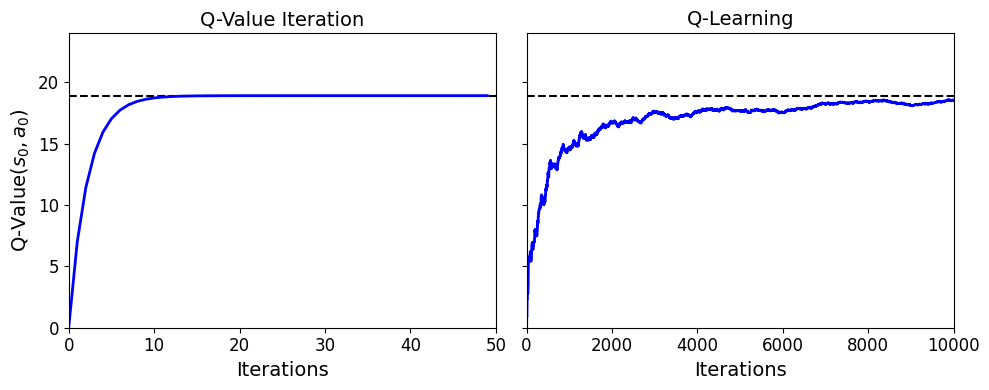

In [53]:
true_Q_value = history1[-1, 0, 0]
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
save_fig("q_value_plot")

## 심층 Q-러닝 구현하기

DQN을 만들어 본다. 상태가 주어지면 가능한 모든 행동에 대해서 행동을 플레이한 후 (하지만 결과를 보기 전에) 기대할 수 있는 할인된 미래 보상의 합을 추정한다:

In [54]:
keras.backend.clear_session()
env = gym.make("CartPole-v1", render_mode="rgb_array")
input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n
model = keras.Sequential(
    [
        keras.layers.Dense(32, "elu", input_shape=input_shape), keras.layers.Dense(32, "elu"),
        keras.layers.Dense(n_outputs)
    ]
)

이 DQN을 사용해 행동을 선택하려면 가장 큰 예측 Q-가치를 가진 행동을 선택하면 된다. 하지만 에이전트가 환경을 탐험하려면 `epsilon` 확률로 랜덤한 행동을 선택한다.

In [55]:
def epsilon_greedy_policy(state, epsilon=0):
    if rng.random() < epsilon:
        return rng.integers(n_outputs)
    Q_values = model.predict(state[np.newaxis], verbose=0, use_multiprocessing=True)
    return np.argmax(Q_values[0])

재생 메모리도 필요하다. 여기에는 에이전트의 경험이 담겨 있다. 형식은 `(obs, action, reward, next_obs, terminated, truncated)`와 같다. `deque` 클래스를 사용할 수 있다(더 강력한 경험 재생의 구현을 위해 딥마인드의 [Reverb 라이브러리](https://github.com/deepmind/reverb)를 참고한다):

In [56]:
from collections import deque

replay_memory = deque(maxlen=2000)

그리고 재생 메모리에서 경험을 샘플링하는 함수를 만든다. 이 함수는 5개의 넘파이 배열 `[states, actions, rewards, next_obs, terminateds, truncateds]`을 반환한다.

In [57]:
def sample_experiences(batch_size):
    indices = rng.integers(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, terminateds, truncateds = [
        np.array([experience[field_index] for experience in batch]) for field_index in range(6)
    ]
    return states, actions, rewards, next_states, terminateds, truncateds

이제 DQN을 사용해 한 스텝을 플레이하는 함수를 만들고 경험을 재생 메모리에 기록할 수 있다:

In [58]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action)
    replay_memory.append((state, action, reward, next_state, terminated, truncated))
    return next_state, terminated, truncated

마지막으로 재생 메모리에서 약간의 경험을 샘플링하고 훈련 스텝을 수행하는 함수를 만들어 본다:

In [59]:
batch_size = 32
discount_rate = .95
optimizer = keras.optimizers.Adam(1e-2)
loss_fn = keras.losses.MeanSquaredError()


def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, terminateds, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0, use_multiprocessing=True)
    max_next_Q_values = np.amax(next_Q_values, 1)
    target_Q_values = rewards + (1 - (terminateds | truncateds)) * discount_rate * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.math.reduce_sum(all_Q_values * mask, 1, True)
        loss = tf.math.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

이제 모델을 훈련해 본다!

In [60]:
rewards = []
best_score = 0

In [61]:
for episode in range(1):  # 600
    obs, _ = env.reset()
    step = 0
    while True:
        epsilon = max(1 - episode / 500, .01)
        obs, terminated, truncated = play_one_step(env, obs, epsilon)
        if terminated | truncated:
            break
        step += 1
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f"Episode: {episode}, Steps: {step + 1:3}, eps: {epsilon:.3f}", end='\r')
    if episode > 50:
        training_step(batch_size)
model.set_weights(best_weights)

그림 저장 dqn_rewards_plot


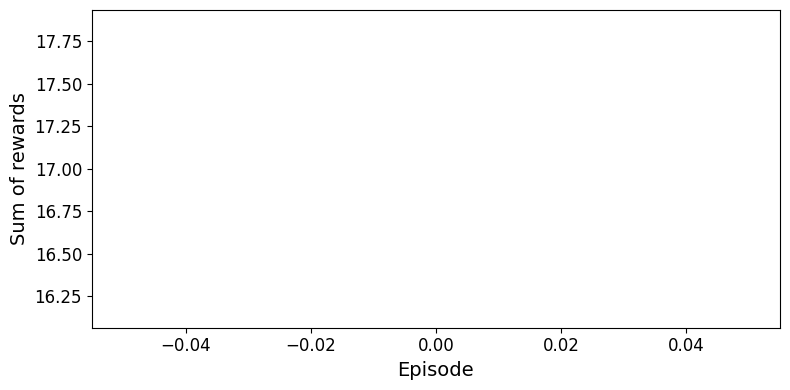

In [62]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [63]:
state, _ = env.reset()
frames = []
while True:
    img = env.render()
    frames.append(img)
    action = epsilon_greedy_policy(state)
    state, _, terminated, truncated, _ = env.step(action)
    if terminated | truncated:
        break
plot_animation(frames)

나쁘지 않다! 😀

## 심층 Q-러닝의 변종

### 더블 DQN

In [64]:
keras.backend.clear_session()
model = keras.Sequential(
    [keras.layers.Dense(32, "elu", input_shape=[4]), keras.layers.Dense(32, "elu"), keras.layers.Dense(n_outputs)]
)
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [65]:
batch_size = 32
discount_rate = .95
optimizer = keras.optimizers.Adam(6e-3)
loss_fn = keras.losses.Huber()


def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, terminateds, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0, use_multiprocessing=True)
    best_next_actions = np.argmax(next_Q_values, 1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states, verbose=0, use_multiprocessing=True) * next_mask).sum(1)
    target_Q_values = rewards + (1 - (terminateds | truncateds)) * discount_rate * next_best_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.math.reduce_sum(all_Q_values * mask, 1, True)
        loss = tf.math.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [66]:
replay_memory = deque(maxlen=2000)

In [67]:
rewards = []
best_score = 0
for episode in range(1):  # 600
    obs, _ = env.reset()
    step = 0
    while True:
        epsilon = max(1 - episode / 500, .01)
        obs, terminated, truncated = play_one_step(env, obs, epsilon)
        if terminated | truncated:
            break
        step += 1
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f"Episode: {episode}, Steps: {step + 1:3}, eps: {epsilon:.3f}", end='\r')
    if episode >= 50:
        training_step(batch_size)
        if not episode % 50:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    # if episode >= 50:
    #     target_weights = target.get_weights()
    #     online_weights = model.get_weights()
    #     for index, online_weight in enumerate(online_weights):
    #         target_weights[index] = .99 * target_weights[index] + .01 * online_weight
    #     target.set_weights(target_weights)
model.set_weights(best_weights)

그림 저장 double_dqn_rewards_plot


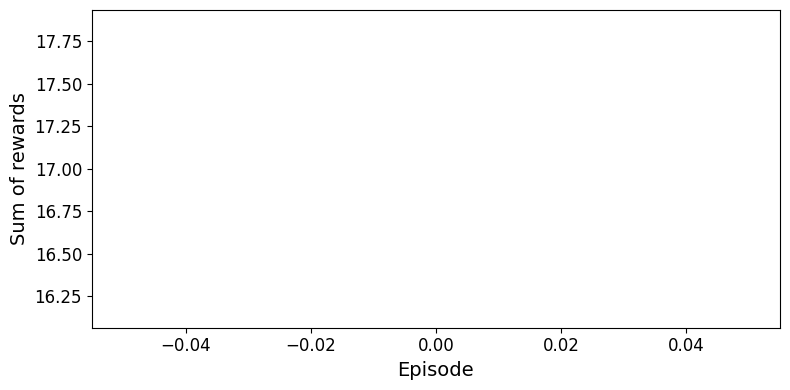

In [68]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [69]:
state, _ = env.reset()
frames = []
while True:
    img = env.render()
    frames.append(img)
    action = epsilon_greedy_policy(state)
    state, _, terminated, truncated, _ = env.step(action)
    if terminated | truncated:
        break
plot_animation(frames)

In [70]:
batch_size = 32
discount_rate = .95
optimizer = keras.optimizers.Adam(7.5e-3)
loss_fn = keras.losses.Huber()


def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, terminateds, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0, use_multiprocessing=True)
    best_next_actions = np.argmax(next_Q_values, 1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states, verbose=0, use_multiprocessing=True) * next_mask).sum(1)
    target_Q_values = rewards + (1 - (terminateds | truncateds)) * discount_rate * next_best_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.math.reduce_sum(all_Q_values * mask, 1, True)
        loss = tf.math.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [71]:
replay_memory = deque(maxlen=2000)

In [72]:
rewards = []
best_score = 0
for episode in range(1):  # 600
    obs, _ = env.reset()
    step = 0
    while True:
        epsilon = max(1 - episode / 500, .01)
        obs, terminated, truncated = play_one_step(env, obs, epsilon)
        if terminated | truncated:
            break
        step += 1
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f"Episode: {episode}, Steps: {step + 1:3}, eps: {epsilon:.3f}", end='\r')
    if episode >= 50:
        training_step(batch_size)
        if not episode % 50:
            target.set_weights(model.get_weights())
model.set_weights(best_weights)

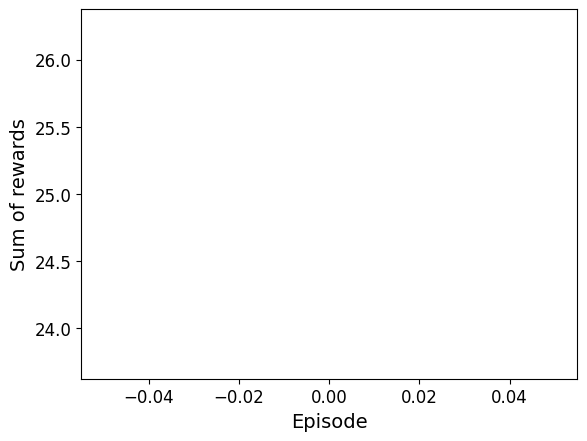

In [73]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [74]:
state, _ = env.reset()
frames = []
while True:
    action = epsilon_greedy_policy(state)
    state, _, terminated, truncated, _ = env.step(action)
    if terminated | truncated:
        break
    img = env.render()
    frames.append(img)
plot_animation(frames)

매우 안정적인 에이전트 같다!

In [75]:
env.close()

## TF-Agents 라이브러리

TF-Agents를 사용해 브레이크아웃 플레이를 학습하는 에이전트를 만들어 본다. 심층 Q-러닝 알고리즘을 사용하겠다. 따라서 이전 구현과 구성 요소를 쉽게 비교할 수 있다. 하지만 TF-Agents에는 다른 (그리고 복잡한) 알고리즘이 많이 구현되어 있다!

### TF-Agents 환경

In [76]:
import suite_gym

env = suite_gym.load("ALE/Breakout-v5", gym_kwargs={"render_mode": "rgb_array"})
env

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [77]:
env.gym

<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Breakout-v5>>>>

In [78]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [79]:
env.step(1)  # Fire

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(1, dtype=int32)})

/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


그림 저장 breakout_plot


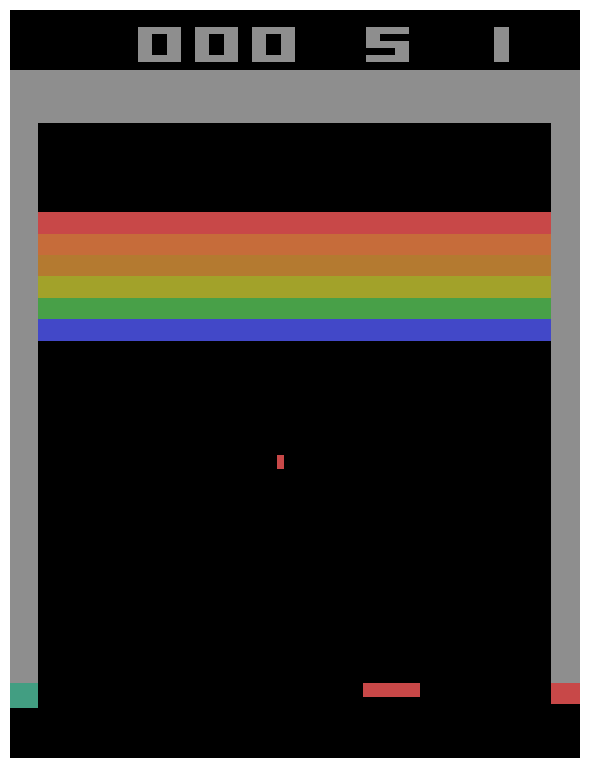

In [80]:
img = env.render()
plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [81]:
env.current_time_step()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
 'reward': array(0., dtype=float32),
 'step_type': array(1, dtype=int32)})

### 환경 스펙

In [82]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [83]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [84]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

### 환경 래퍼와 아타리 전처리

TF-Agents 래퍼로 Gymnasium 환경을 감쌀 수 있다:

In [85]:
from tf_agents.environments import ActionRepeat

repeating_env = ActionRepeat(env, 4)
repeating_env

In [86]:
repeating_env.unwrapped

가능한 래퍼 목록은 다음과 같다:

In [87]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.PyEnvironmentBaseWrapper):
        n = '\n'
        print(f"{name:27s} {obj.__doc__.split(n)[0]}")

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
ExtraDisabledActionsWrapper Adds extra unavailable actions.
FixedLength                 Truncates long episodes and pads short episodes to have a fixed length.
FlattenActionWrapper        Flattens the action.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_h

In [88]:
from functools import partial
from gymnasium.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "ALE/Breakout-v5",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)]
)

In [89]:
limited_repeating_env

In [90]:
limited_repeating_env.unwrapped

아타리 브레이크아웃 환경을 만들고 기본 아타리 전처리 단계를 적용한다:

**경고**: 브레이크아웃은 게임 시작과 죽을 때마다 FIRE 버튼을 눌러야 한다. 처음에는 FIRE 버튼을 누르는 것이 빨리 지는 것처럼 보이기 때문에 에이전트가 이를 배우는데 매우 오랜 시간이 걸릴 수 있다. 훈련 속도를 높이려면 `AtariPreprocessing` 래퍼 클래스를 상속하여 `AtariPreprocessingWithAutoFire`를 만들고 사용한다. 이 클래스는 게임 시작과 말이 죽을 때마다 자동으로 FIRE(즉 플레이 행동 1)를 누른다.

In [91]:
from gymnasium.wrappers import AtariPreprocessing
from frame_stack import FrameStack

max_episode_steps = 27000  # <=> 108k ALE 프레임(1단계 = 4 프레임이므로)
environment_name = "ALE/Breakout-v5"


class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1)  # 시작하려면 FIRE
        return obs

    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, terminated, truncated, info = super().step(action)
        if self.ale.lives() < lives_before_action and not terminated | truncated:
            super().step(1)  # 생명을 잃은 후 시작하기 위해 FIRE
        return obs, rewards, terminated, truncated, info


env = suite_gym.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, partial(FrameStack, num_stack=4)],
    gym_kwargs={"frameskip": 1}
)

In [92]:
env

몇 개의 스텝을 플레이하고 어떻게 동작하는지 확인한다:

In [93]:
env.reset()
for _ in range(4):
    time_step = env.step(3)  # 왼쪽

In [94]:
def plot_observation(obs):
    # 컬러 채널이 3개이기 때문에 4 프레임을 출력할 수 없다.
    # 따라서 현재 프레임과 다른 프레임의 평균 값을 뺀 차이를 계산한다.
    # 그다음 이 차이를 현재 프레임의 빨강과 파랑 채널에 더해서 보라 색을 구한다.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

그림 저장 preprocessed_breakout_plot


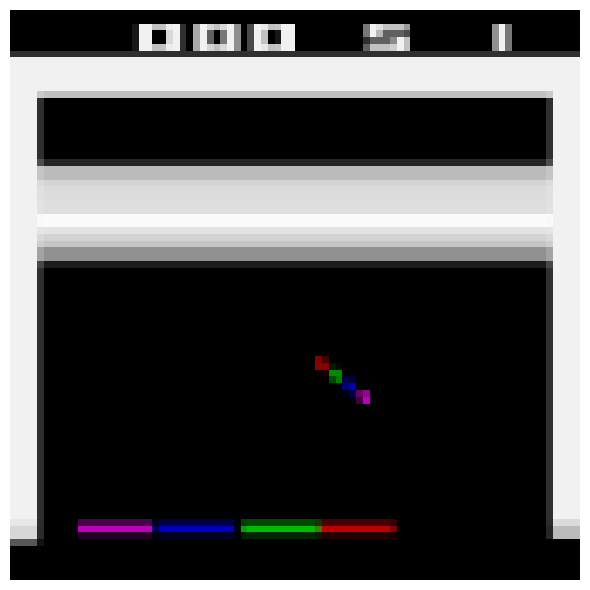

In [95]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

파이썬 환경을 TF 환경으로 변환한다:

In [96]:
from tf_agents.environments import TFPyEnvironment

tf_env = TFPyEnvironment(env)

### 심층 Q-네트워크 만들기

관측을 정규화하는 작은 클래스를 만든다. 이미지를 0 ~ 255 사이의 바이트로 저장하는 것이 램을 적게 사용하지만 신경망에는 0.0 ~ 1.0 사이의 실수를 전달해야 한다:

Q-네트워크를 만든다:

In [97]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

DQN 에이전트를 만든다:

In [98]:
from tf_agents.agents import DqnAgent

train_step = tf.Variable(0)
update_period = 4  # 4 스텝마다 모델을 훈련한다.
optimizer = keras.optimizers.experimental.RMSprop(2.5e-4, .95, epsilon=.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    1., 250000 // update_period, .01  # 초기 ε, <=> 1,000,000 ALE 프레임, 마지막 ε
)
agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_net,
    optimizer,
    epsilon_greedy=lambda: epsilon_fn(train_step),
    target_update_period=2000,  # <=> 32,000 ALE 프레임
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=.99,  # 할인 계수
    train_step_counter=train_step
)
agent.initialize()

2023-06-11 08:47:51.164374: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


재생 버퍼를 만든다(램을 많이 사용하기 때문에 메모리 부족 에러가 나오면 버퍼 크기를 줄인다):

**경고**: 1,000,000이 아닌 100,000 크기의 재생 버퍼를 사용한다. 대부분의 경우 메모리 부족 에러가 나기 때문이다.

In [99]:
from tf_agents.replay_buffers import TFUniformReplayBuffer

replay_buffer = TFUniformReplayBuffer(agent.collect_data_spec, tf_env.batch_size, 100000)  # OOM 에러가 나면 줄인다
replay_buffer_observer = replay_buffer.add_batch

2023-06-11 08:47:51.707560: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2822400000 exceeds 10% of free system memory.


호출 횟수를 카운트하고 출력하는 간단한 사용자 정의 옵저버를 만든다(하나의 스텝으로 카운트하지 않는 두 에피소드 사이의 경계는 제외한다):

In [100]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total

    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print(f"\r{self.counter}/{self.total}", end='')

훈련 측정 지표를 추가해 본다:

In [101]:
import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

In [102]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [103]:
import logging

from tf_metrics import log_metrics

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0
